<a href="https://colab.research.google.com/github/danpires97/IA/blob/main/Prova2_IA_Daniel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Aluno: Daniel de Sá Pires</h1>
<h3>Matrícula: 20170015710</h3>



<h1>Questão 1</h1>

Utilizando a base de dados de https://www.kaggle.com/datasets/devzohaib/estimating-the-age-of-abalone-at-a-seafood-farm, elabore uma solução para identificar o OUTPUT idade do animal. Lembre-se de comentar seu código no notebook detalhadamente, explicando cada passo.</br>
</br>
A) Faça o pré-processamento dos dados (limpeza, engenharia de variáveis, etc) e deixe os seus dados preparados para aplicar o modelo.</br>
OBS: Utilize pelo menos uma forma de redimensionamento de atributos (selecionando ou agregando) e avalie o resultado de utilizar todas eles e essa amostra.</br></br>
B) Teste algoritmos de Árvore de Decisão e MLP. Para o melhor algoritmo, teste 2 variações de um dos seus hiperparâmetros.</br></br>
C) Para avaliar os resultados, escolha 1 métrica de erro.

In [ ]:
pip install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import statistics as st
%pylab inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, cluster, neighbors, svm, metrics, tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score #treino e validação
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPRegressor
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

Populating the interactive namespace from numpy and matplotlib


In [ ]:
tab = pd.read_csv('/content/sample_data/abalone.csv', delimiter=",")
tab.head(10)

,sex,length,diameter,height,whole_wt,shucked_wt,viscera_wt,shell_wt,rings,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5
5,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8,9.5
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20,21.5
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16,17.5
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9,10.5
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19,20.5


In [ ]:
tab.duplicated().sum() #Checandos os dados duplicados

0

In [ ]:
tab.isnull().sum() #Checando os dados nulos

sex           0
length        0
diameter      0
height        0
whole_wt      0
shucked_wt    0
viscera_wt    0
shell_wt      0
rings         0
age           0
dtype: int64

In [ ]:
tab = tab.replace(to_replace="F", value="0") #Subtituindo atributo qualitativo por quantitativo
tab = tab.replace(to_replace="M", value="1")
tab = tab.replace(to_replace="I", value="2")
tab['sex'] = pd.to_numeric(tab['sex'])

In [ ]:

featuresList = list(tab.columns[0:9]) #Dividiu somente os atributos de dados
features = tab[featuresList]

targetList = list(tab.columns[9:10]) #Separou o alvo, que é 'age'
targetPassing = tab[targetList]


scaler = preprocessing.StandardScaler().fit(features)

scaled = scaler.fit_transform(features)
lista_corr = pd.DataFrame(scaled, columns=features.columns)

lista_corr = pd.concat([lista_corr, targetPassing], axis=1)

lista_corr

,sex,length,diameter,height,whole_wt,shucked_wt,viscera_wt,shell_wt,rings,age
0,-0.010522,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217,1.571544,16.5
1,-0.010522,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987,-0.910013,8.5
2,-1.266308,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139,-0.289624,10.5
3,-0.010522,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294,0.020571,11.5
4,1.245263,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757,-0.910013,8.5
...,...,...,...,...,...,...,...,...,...,...
4172,-1.266308,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062,0.330765,12.5
4173,-0.010522,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685,0.020571,11.5
4174,-0.010522,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955,-0.289624,10.5
4175,-1.266308,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739,0.020571,11.5


In [ ]:
corr_abalone = lista_corr.corr() #função para verificar a correlação entre as variáveis
corr_abalone.style.background_gradient(cmap='coolwarm')

,sex,length,diameter,height,whole_wt,shucked_wt,viscera_wt,shell_wt,rings,age
sex,1.000000,-0.503697,-0.516450,-0.477850,-0.501511,-0.459731,-0.505693,-0.499103,-0.401445,-0.401445
length,-0.503697,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720,0.556720
diameter,-0.516450,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660,0.574660
height,-0.477850,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467,0.557467
whole_wt,-0.501511,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390,0.540390
shucked_wt,-0.459731,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884,0.420884
viscera_wt,-0.505693,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819,0.503819
shell_wt,-0.499103,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574,0.627574
rings,-0.401445,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000,1.000000
age,-0.401445,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000,1.000000


Da tabela vemos que o atributo age tem uma relação extremamente forte com o **número de anéis**, alcançado o valor max de 1. A partir disso, iremos selecionar o atributo para análise.

In [ ]:
#tab['weight'] = (tab['whole_wt'] + tab['shucked_wt'] + tab['viscera_wt'] + tab['shell_wt'])/4 #Agrupamento das 4 variáveis relac. a peso
'''tab['body_measurements'] = (tab['length'] + tab['height'] + tab['diameter'])/3

tab = tab.drop(columns=['shucked_wt','viscera_wt','shell_wt'])
tab = tab.drop(columns=['length','height','diameter','rings'])
tab.head(10)'''

"tab['body_measurements'] = (tab['length'] + tab['height'] + tab['diameter'])/3\n\ntab = tab.drop(columns=['shucked_wt','viscera_wt','shell_wt'])\ntab = tab.drop(columns=['length','height','diameter','rings'])\ntab.head(10)"

In [ ]:
aux = tab['rings'];
select_atrib = pd.DataFrame(aux,columns=['rings'])
select_atrib = pd.concat([select_atrib, targetPassing], axis=1) #Concatenando o dataframe de 'rings' com o 'age'

select_atrib #nossos dados para treinamento com um atributo selecionado

,rings,age
0,15,16.5
1,7,8.5
2,9,10.5
3,10,11.5
4,7,8.5
...,...,...
4172,11,12.5
4173,10,11.5
4174,9,10.5
4175,10,11.5


In [ ]:
#Separando as amostras para o treino e para o teste, foram feitos para os dois tipos, com e sem seleção de atributos
normal_treino = lista_corr.sample(frac=0.7, random_state = 107)
resultado_treino = lista_corr['age'].sample(frac=0.7, random_state = 107)
normal_teste = pd.concat([lista_corr, normal_treino]).drop_duplicates(keep=False)

select_treino = lista_corr.sample(frac=0.7, random_state = 107) 
select_teste = pd.concat([lista_corr, select_treino]).drop_duplicates(keep=False)

select_teste

,sex,length,diameter,height,whole_wt,shucked_wt,viscera_wt,shell_wt,rings,age
1,-0.010522,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987,-0.910013,8.5
2,-1.266308,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139,-0.289624,10.5
3,-0.010522,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294,0.020571,11.5
4,1.245263,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757,-0.910013,8.5
9,-1.266308,0.216591,0.323686,0.250672,0.134109,-0.202164,-0.270012,0.583170,2.812322,20.5
...,...,...,...,...,...,...,...,...,...,...
4158,1.245263,-0.366361,-0.532927,-0.705762,-0.773442,-0.713572,-0.835699,-0.710063,-0.599818,9.5
4162,-0.010522,-1.157510,-1.540707,-0.944870,-1.042648,-1.001942,-1.027303,-1.054925,-0.599818,9.5
4164,1.245263,-1.115871,-1.187984,-0.944870,-1.109950,-1.053759,-1.068361,-1.133956,-0.910013,8.5
4166,1.245263,-0.408000,-0.432149,-0.586208,-0.672490,-0.573892,-0.840261,-0.595109,0.020571,11.5


# **Usando a Árvore de Decisão**

In [ ]:
normal_entrada = normal_teste

normal_regressorTree = DecisionTreeRegressor(random_state = 2) 
select_regressorTree = DecisionTreeRegressor(random_state = 2) 
  
#Agora iremos treinar os Regressores, as bases que tem _X, são os dados, e as que tem _Y são as saídas esperadas, os alvos.
X = normal_treino
Y = resultado_treino

selec_X = select_treino.drop(labels=['sex', 'length' ,'diameter', 'height', 'whole_wt', 'shucked_wt', 'viscera_wt', 'shell_wt','age'], axis=1)
selec_Y = resultado_treino
normal_regressorTree.fit(X, Y)
select_regressorTree.fit(selec_X, selec_Y)

DecisionTreeRegressor(random_state=2)

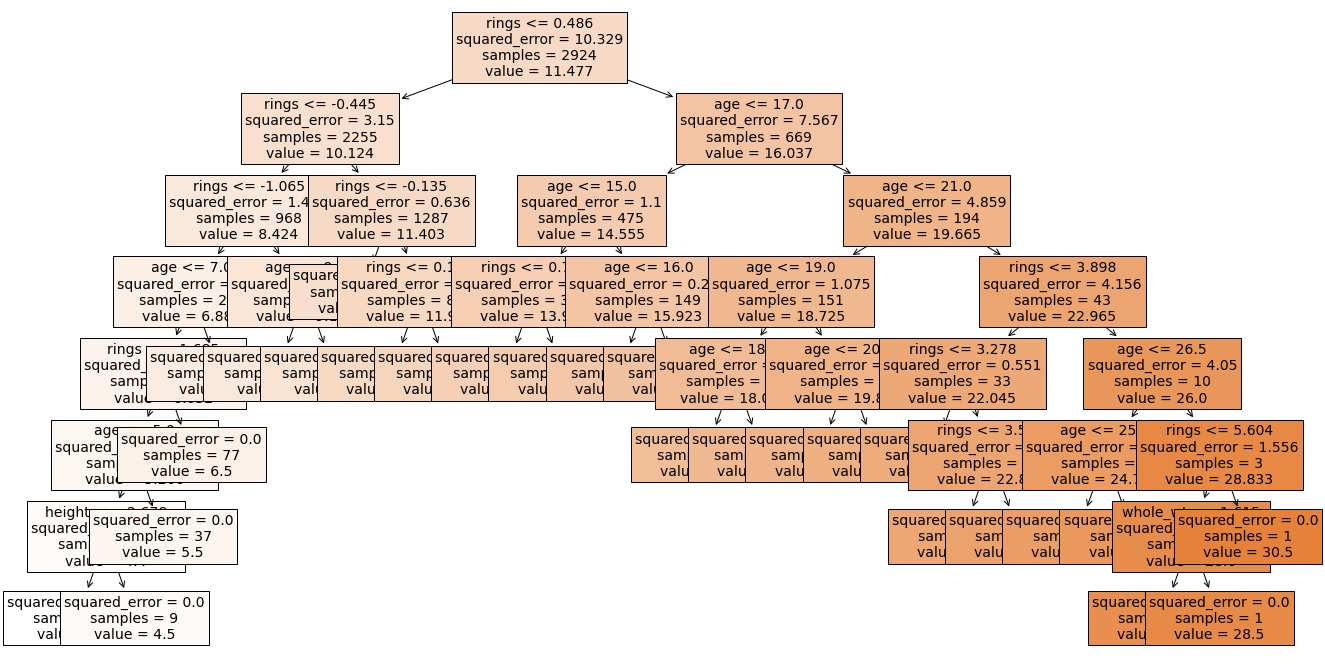

In [ ]:
plt.figure(figsize=(22,12))
plot_tree(normal_regressorTree, filled=True, fontsize=14, feature_names=X.columns)
plt.show()

O plot_tree nos mostra duas classes separadas pelo atribute idade, já que limitei a profundidade da árvore igual a 1. A classe do lado esquerdo(971 exemplos) são os valores menores que 13 na idade, com previsão de 8.5 para esta classe. Já para as classes do lado direito(282 exemplos) a previsão é de 14,78 para o valor de idade.

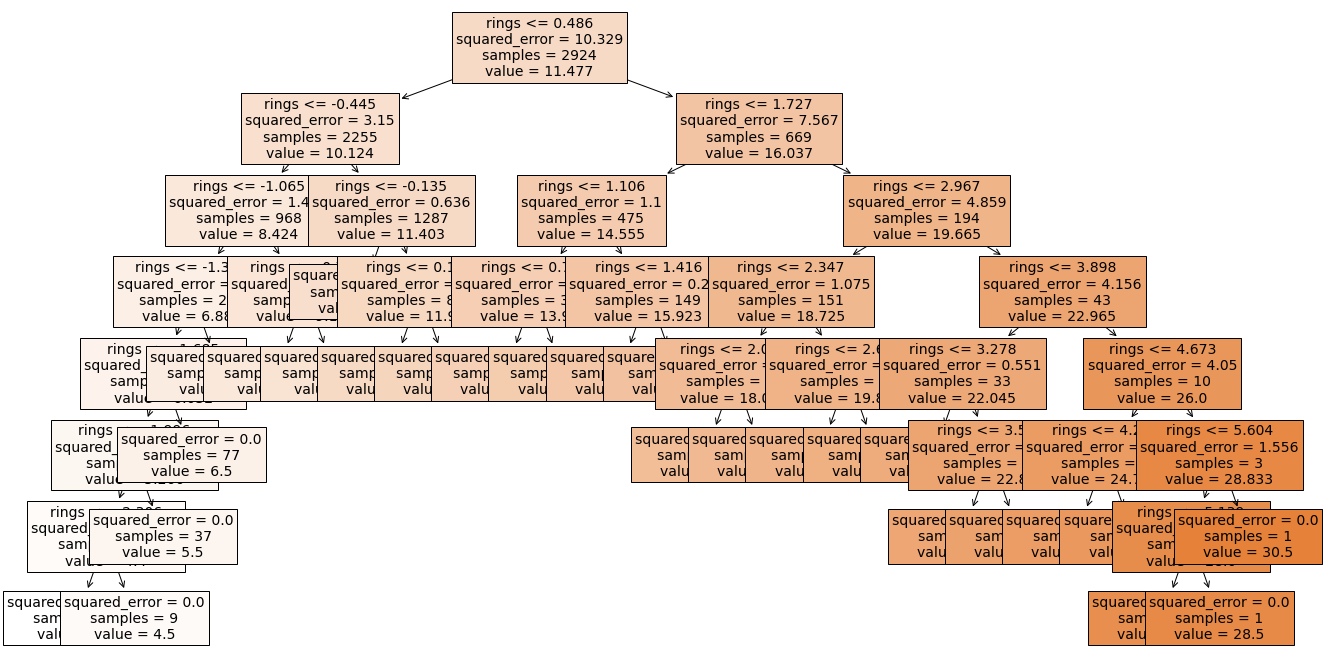

In [ ]:
plt.figure(figsize=(22,12))
plot_tree(select_regressorTree, filled=True, fontsize=14, feature_names=selec_X.columns)

plt.show()

max_depth = None => Erro = 0.1294


---


max_depth = 1 => Erro = 2.0586
samples_leaf = 1 => Erro = 0.1294


---


max_depth = 2 => Erro 1.1393
samples_leaf = 2 => Erro = 0.1588


---


max_depth = 4 => Erro = 0.2915
samples_leaf = 4 => Erro = 0.1644


---


max_depth = 7 => Erro = 0.2178
samples_leaf = 7 => Erro = 0.2178



---

max_depth = 12 => Erro = 0.1294
samples_leaf = 12 => Erro = 0.2421

In [ ]:
resultado = normal_teste["age"]

print ("Coef. de determinação: Normal", normal_regressorTree.score(normal_teste,normal_resultado)*100)

Coef. de determinação: Normal 99.96967431472544


In [ ]:
selec_resultado = select_teste["age"]
selec_entrada = select_teste.drop(labels=['sex', 'length' ,'diameter', 'height', 'whole_wt', 'shucked_wt', 'viscera_wt', 'shell_wt','age'], axis=1)

print("Coef.de determinação: Selecionado", select_regressorTree.score(selec_entrada,selec_resultado)*100)

Coef.de determinação: Selecionado 99.98483715736272


# **Regressão usando MLP**

In [ ]:
normal_entrada = normal_teste #Teste para os regressores


MLP_normal = MLPRegressor(random_state=2)
MLP_select = MLPRegressor(random_state=2)

MLP_normal.fit(X,Y)
MLP_select.fit(selec_X,selec_Y)

print ("Coef.de Determinação: Dados Normais", MLP_normal.score(normal_entrada,resultado)*100,"%")
print ("Coef. de Determinação: Dados Selecionados", MLP_select.score(selec_entrada,resultado)*100,"%")

Coef.de Determinação: Dados Normais 99.98589445019932 %
Coef. de Determinação: Dados Selecionados 99.68696369123109 %


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Com os resultados em mãos, podemos ver que o atributo 'rings' que tem correlação 1:1 apresentou melhores resultados com a base de dados normal. O que indica que na outra base deve haver algum tipo de ruído que fez diferença nas métricas.

Assim, como esperado, os outros dados não apresentam tanta importância como o atributo rings.

**2º Questão**

Utilize a mesma base de dados (lembrem de tirar o rótulo, obviamente) da questão anterior de forma que:


---


a) Execute o K-means e Hierárquico.
b) Teste o K igual à 3 e 5.
c) Na execução do Hierárquico, varie 2 métodos do linkage; OBS.: utilize os mesmos valores de clusters escolhidos na questão anterior.
d) Por fim, faça uma comparação entre os 2 resultados das execuções anteriores e adote uma medida de avaliação própria para clusterização.


Centro dos clusters
[[ 0.75567607 -1.01348821 -1.02418562 -0.92160539 -0.90302354 -0.95267773
  -0.97296969 -0.85782485  8.66824324]
 [-0.44876584  0.53916875  0.59002827  0.68960617  0.32548794  0.53931428
   0.89081174  2.02480747 17.96122449]
 [-0.40711614  0.55993197  0.55581371  0.4649157   0.53329667  0.51912054
   0.45468844  0.12570236 11.83892161]]
Previsões para o k=5
[1 0 2 ... 2 2 2]


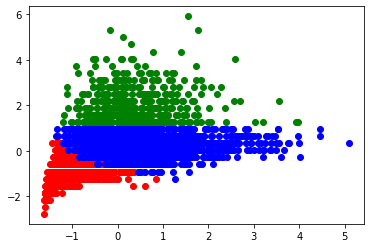

In [ ]:
#Defini o rotulo para o problema como 'whole_wt'

atrib_sem_whole_wt= lista_corr.drop("whole_wt",axis=1)

#k = 3
kmeans = KMeans(n_clusters=3, random_state=0).fit(atrib_sem_whole_wt)
kmeans_k3_predicao = kmeans.predict(atrib_sem_whole_wt)

print("Centro dos clusters")
print(kmeans.cluster_centers_)
kmeans_k3_pontuacao = kmeans.score(atrib_sem_whole_wt)

print("Previsões para o k=5")
print(kmeans_k3_predicao)

#Plotando Grafico 2D entre rings e diameter
label_0 = atrib_sem_whole_wt[kmeans_k3_predicao == 0]
label_1 = atrib_sem_whole_wt[kmeans_k3_predicao == 1]
label_2 = atrib_sem_whole_wt[kmeans_k3_predicao == 2]

plt.scatter(label_0["shucked_wt"], label_0["rings"], color = 'red')
plt.scatter(label_1["shucked_wt"], label_1["rings"], color = 'green')
plt.scatter(label_2["shucked_wt"], label_2["rings"], color = 'blue')

plt.show()

No gráfico fica claro que existem regiões distintas, como se houvessem fronteiras definidas entre os grupos. Os dados do grupo vermelho se concentram prioritariamente à esquerda, os dados da cor azul atingem uma faixa maior do gráfico. Já os dados verdes atingem a parte alta do gráfico e são concentrados da esquerda até o centro.

Centro dos Clusters
[[ 9.99146454e-01 -1.43748216e+00 -1.44611608e+00 -1.26048168e+00
  -1.13863249e+00 -1.18571291e+00 -1.21648208e+00 -1.13414413e+00
   7.77744982e+00]
 [-4.96805211e-01  6.98722020e-01  7.52743420e-01  8.87615481e-01
   4.78872914e-01  7.05304206e-01  1.25303769e+00  2.64732473e+00
   1.99680851e+01]
 [ 9.59596236e-02 -1.09433904e-01 -1.20068855e-01 -1.83392929e-01
  -2.75704203e-01 -3.17358193e-01 -3.38136479e-01 -3.13100383e-01
   1.04243167e+01]
 [-3.95395317e-01  2.49479326e-01  2.85740169e-01  3.40703644e-01
  -1.57691811e-03  1.69489766e-01  3.24762646e-01  1.09076915e+00
   1.49500876e+01]
 [-5.84039634e-01  9.72704832e-01  9.62758645e-01  8.44301068e-01
   1.13602270e+00  1.08900988e+00  9.41638790e-01  1.48098296e-01
   1.19111212e+01]]
Previsões para k=5
[3 0 2 ... 4 4 4]


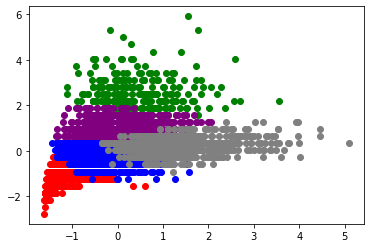

In [ ]:
# K = 5
kmeans5 = KMeans(n_clusters=5, random_state=0).fit(atrib_sem_whole_wt)
kmeans_k5_predicao = kmeans5.predict(atrib_sem_whole_wt)

print("Centro dos Clusters")
print(kmeans5.cluster_centers_)

kmeans_k5_pontuacao = kmeans5.score(atrib_sem_whole_wt)

print("Previsões para k=5")
print(kmeans_k5_predicao)

#Plotando Grafico 2D entre rings e diameter
label5_0 = atrib_sem_whole_wt[kmeans_k5_predicao == 0]
label5_1 = atrib_sem_whole_wt[kmeans_k5_predicao == 1]
label5_2 = atrib_sem_whole_wt[kmeans_k5_predicao == 2]
label5_3 = atrib_sem_whole_wt[kmeans_k5_predicao == 3]
label5_4 = atrib_sem_whole_wt[kmeans_k5_predicao == 4]

plt.scatter(label5_0["shucked_wt"], label5_0["rings"], color = 'red')
plt.scatter(label5_1["shucked_wt"], label5_1["rings"], color = 'green')
plt.scatter(label5_2["shucked_wt"], label5_2["rings"], color = 'blue')
plt.scatter(label5_3["shucked_wt"], label5_3["rings"], color = 'purple')
plt.scatter(label5_4["shucked_wt"], label5_4["rings"], color = 'gray')

plt.show()

Com k=5 percebemos que mesmo com regiões bem distintas, os grupos se misturam mais e com pouca tendência de ocupar a parte central do gráfico.

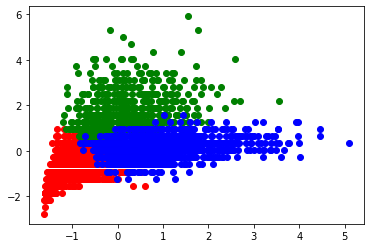

In [ ]:

cruster_aglomera_3 = AgglomerativeClustering(n_clusters = 3)
cruster_predict_3A = cruster_aglomera_3.fit_predict(atrib_sem_whole_wt)

#Plotando Grafico 2D entre rings e diameter
labelA_0 = atrib_sem_whole_wt[cruster_predict_3A == 0]
labelA_1 = atrib_sem_whole_wt[cruster_predict_3A == 1]
labelA_2 = atrib_sem_whole_wt[cruster_predict_3A == 2]

plt.scatter(labelA_0["shucked_wt"], labelA_0["rings"], color = 'red')
plt.scatter(labelA_1["shucked_wt"], labelA_1["rings"], color = 'green')
plt.scatter(labelA_2["shucked_wt"], labelA_2["rings"], color = 'blue')

plt.show()

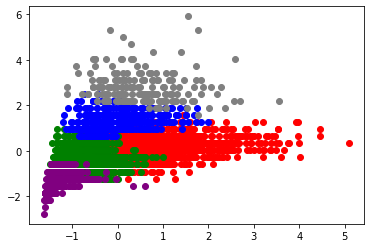

In [ ]:
#Aplicando Aglomeração para k=5 

cruster_aglomera_5 = AgglomerativeClustering(n_clusters = 5)
cruster_predict_5A = cruster_aglomera_5.fit_predict(features_sem_sex)

#Plotando Grafico 2D entre rings e diameter
label5A_0 = atrib_sem_whole_wt[cruster_predict_5A == 0]
label5A_1 = atrib_sem_whole_wt[cruster_predict_5A == 1]
label5A_2 = atrib_sem_whole_wt[cruster_predict_5A == 2]
label5A_3 = atrib_sem_whole_wt[cruster_predict_5A == 3]
label5A_4 = atrib_sem_whole_wt[cruster_predict_5A == 4]

plt.scatter(label5A_0["shucked_wt"], label5A_0["rings"], color = 'red')
plt.scatter(label5A_1["shucked_wt"], label5A_1["rings"], color = 'green')
plt.scatter(label5A_2["shucked_wt"], label5A_2["rings"], color = 'blue')
plt.scatter(label5A_3["shucked_wt"], label5A_3["rings"], color = 'purple')
plt.scatter(label5A_4["shucked_wt"], label5A_4["rings"], color = 'gray')

plt.show()

Gráfico muito semelhante ao problema do K-means com fronteiras bem definidas. Agora falta alterar o linkage.

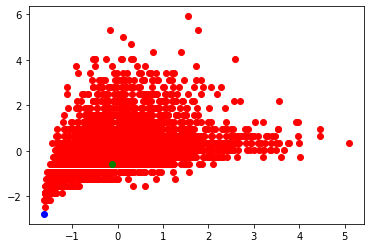

In [ ]:
cruster_aglomera_3 = AgglomerativeClustering(n_clusters = 3,linkage="average")
cruster_predict_3A = cruster_aglomera_3.fit_predict(features_sem_sex)

labelA_0 = atrib_sem_whole_wt[cruster_predict_3A == 0]
labelA_1 = atrib_sem_whole_wt[cruster_predict_3A == 1]
labelA_2 = atrib_sem_whole_wt[cruster_predict_3A == 2]

plt.scatter(labelA_0["shucked_wt"], labelA_0["rings"], color = 'red')
plt.scatter(labelA_1["shucked_wt"], labelA_1["rings"], color = 'green')
plt.scatter(labelA_2["shucked_wt"], labelA_2["rings"], color = 'blue')

plt.show()

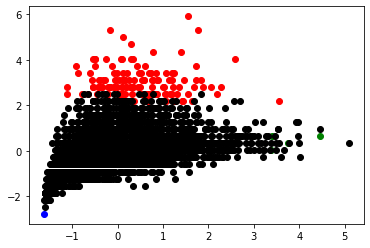

In [ ]:
cruster_aglomera_5 = AgglomerativeClustering(n_clusters = 5, linkage="average")
cruster_predict_5A = cruster_aglomera_5.fit_predict(features_sem_sex)

#Plotando Grafico 2D Baseado em anéis(Y) e Diametro(X)
label5A_0 = atrib_sem_whole_wt[cruster_predict_5A == 0]
label5A_1 = atrib_sem_whole_wt[cruster_predict_5A == 1]
label5A_2 = atrib_sem_whole_wt[cruster_predict_5A == 2]
label5A_3 = atrib_sem_whole_wt[cruster_predict_5A == 3]
label5A_4 = atrib_sem_whole_wt[cruster_predict_5A == 4]

plt.scatter(label5A_0["shucked_wt"], label5A_0["rings"], color = 'red')
plt.scatter(label5A_1["shucked_wt"], label5A_1["rings"], color = 'green')
plt.scatter(label5A_2["shucked_wt"], label5A_2["rings"], color = 'blue')
plt.scatter(label5A_3["shucked_wt"], label5A_3["rings"], color = 'purple')
plt.scatter(label5A_4["shucked_wt"], label5A_4["rings"], color = 'gray')

plt.show()

Percebemos que houve uma parda de qualidade ao longo do processo, devido a abordagem feito aos Outliers. Os métodos Sklearn e Average não se mostraram muito úteis, já que os pontos ficaram muito agrupados.